# ** IMPORT PACKAGES: **

In [1]:
# python peripherals
import random
import os
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils

# ipython
from IPython.display import display, HTML

# ** GLOBAL SETTINGS: **

In [2]:
curvature_type = 'equiaffine'
# plt.style.use("dark_background")

if curvature_type == 'euclidean':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_euclidean_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_euclidean_arclength_tuplets_results_dir_path
elif curvature_type == 'equiaffine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_equiaffine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_equiaffine_arclength_tuplets_results_dir_path

# ** SANITY CHECK - CURVES: **

In [ ]:
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
limit = 10
color_map = plt.get_cmap('rainbow', limit)
for i, curve in enumerate(curves[:limit]): 
    fig, ax = plt.subplots(1, 1, figsize=(80,40))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(30)
    ax.axis('equal')
    notebook_utils.plot_curve(ax=ax, curve=curve, linewidth=5)
    plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = DeepSignatureTupletsDataset()
dataset.load_dataset(dir_path=level_curves_arclength_tuplets_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
# numpy.random.shuffle(indices)
sampler = SubsetRandomSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random sample of tuplets:</h3>'))
for tuplet_index, data in enumerate(data_loader, 0):
    if tuplet_index == 35:
        break

    curve1 = torch.squeeze(torch.squeeze(data['input'])[0])
    curve2 = torch.squeeze(torch.squeeze(data['input'])[1])
    curve3 = torch.squeeze(torch.squeeze(data['input'])[2])
    # curve4 = torch.squeeze(torch.squeeze(data['input'])[3])

    display(HTML(f'<h3>Sample #{tuplet_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()
    curve3 = curve3.cpu().numpy()
    # curve4 = curve4.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.axis('equal')

    # print(data['curve'][0].shape)
    # print(data['anchor_indices'][0].cpu().numpy())
    # print(data['positive_indices1'][0].cpu().numpy())
    # print(data['positive_indices2'][0].cpu().numpy())

    # plot_curve(ax=ax, curve=data['curve'][0].cpu().numpy(), linewidth=2)

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=30,
        color='lightcoral',
        zorder=150)

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=20,
        color='skyblue',
        zorder=50)

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve3, 
        point_size=20,
        color='springgreen',
        zorder=50)

    # print(curve1)
    # print(curve2)
    # print(curve3)

    # plot_sample(
    #     ax=ax, 
    #     sample=curve4, 
    #     point_size=50,
    #     color='gold',
    #     zorder=50)

    # plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAIN/VALIDATION LOSS **

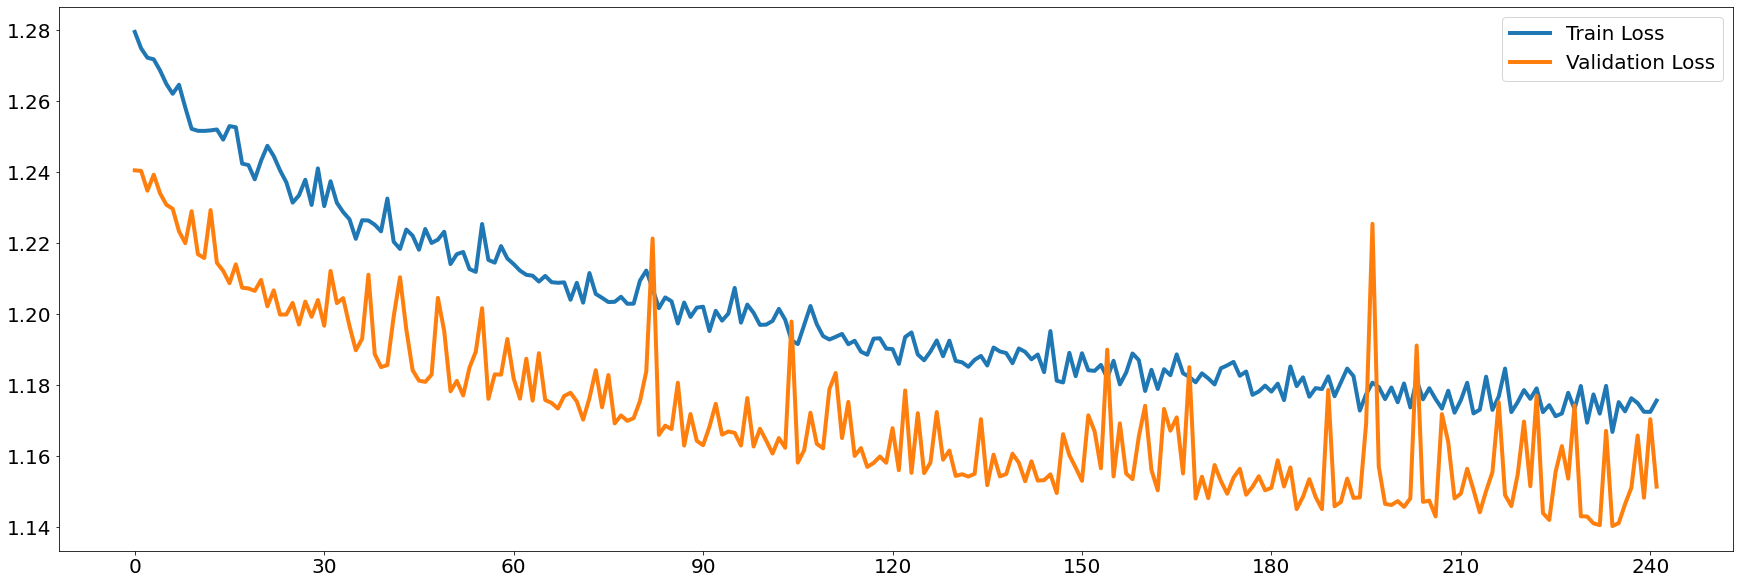

In [7]:
latest_subdir = common_utils.get_latest_subdirectory(level_curves_arclength_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

# results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array'][1:]
validation_loss_array = results['validation_loss_array'][1:]

# train_loss_array2 = results2['train_loss_array']
# validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
# epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

# ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
# ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

In [ ]:
sample_points = 40
supporting_points_count = 40
max_offset = 4
limit = 40
numpy.random.seed(60)

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureArcLengthNet(sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
# model.load_state_dict(torch.load("C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/model_349.pt", map_location=device))
model.eval()

curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]
color_map = plt.get_cmap('rainbow', limit)

for curve_index, curve in enumerate(curves):
    if curve_index == 25:
        break
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.axis('equal')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)

    # plot predicted curvature
    predicted_arclength = numpy.zeros(curve.shape[0])
    for i in range(curve.shape[0]):
        if i == 1:
            break

        sample1_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count - 1)
        sample1 = curve_processing.normalize_curve(curve=sample1_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()

        sample2_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i+supporting_points_count - 1,
            end_point_index=i+2*supporting_points_count - 2)
        sample2 = curve_processing.normalize_curve(curve=sample2_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()

        sample3_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count - 2)
        sample3 = curve_processing.normalize_curve(curve=sample3_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data3 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample3).double(), dim=0), dim=0).cuda()

        sample4_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count)
        sample4 = curve_processing.normalize_curve(curve=sample4_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data4 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample4).double(), dim=0), dim=0).cuda()

        sample5_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count)
        sample5 = curve_processing.normalize_curve(curve=sample5_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data5 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample5).double(), dim=0), dim=0).cuda()

        print('------------ 4 + 5 -----------')
        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data4), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data5), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(2 * s1)
            print('-----------------------')

        plot_sample(
            ax=ax, 
            sample=sample1, 
            point_size=20,
            color='lightcoral',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample2, 
            point_size=20,
            color='skyblue',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample3, 
            point_size=20,
            color='springgreen',
            zorder=150)

        plot_sample(ax, numpy.array([[sample1[0,0] ,sample1[0, 1]]]), point_size=50, alpha=1, color='white', zorder=200)

        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()
            s3 = torch.squeeze(model(batch_data3), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(s1+s2)
            print(s3)
            print('-----------------------')

        for j in range(60):
            sample1 = curve_sampling.sample_curve_section2(
                curve=curve,
                supporting_points_count=sample_points,
                start_point_index=i,
                end_point_index=i+supporting_points_count + j)
            sample1 = curve_processing.normalize_curve(curve=sample1, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
            batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
            with torch.no_grad():
                s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
                print(s1)
            
        print('-----------------------')

    plt.show()